In [1]:
Legi =18820068

# SLT-CE-1: Sampling

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC)
 sampling procedures [1] introduced during the lecture. We will first tackle
 the image reconstruction problem followed by the traveling salesman problem.

## Background (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one
 needs to recover the original through denoising. To do so we will use the
 prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from
 physics as explained in section 8.3.3 of [2]. An undirected graphical
 model is designed to model (i) the adherence of the reconstruction to the
 observed noisy image and (ii) the correlation between neighboring pixels.
 We are interested in recovering a single image, the most likely one, with
 respect to the underlying distribution i.e. we do MAP inference to discover
  the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 
[0] [SLT ](https://ml2.inf.ethz.ch/courses/slt/)

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is
the value of the i-th pixel, the Ising model tries to find a denoised image
$x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel
neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding
pixels. In this exercise we consider only the 4 pixel neigbourhood (up,
down, left and right pixels). The undirected probabilistic graphical model
from where the energy function $E(x|y)$ is derived, is explained in more
detail in [2]. Note that $\beta$ denotes the interaction between pixels and is
not to be mistaken for the inverse temperature, which sometimes is also
denoted as $\beta$.

 <h2> Setup </h2>

We start by importing necessary python packages.

In [2]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time

from skimage.transform import resize
from scipy.signal import fftconvolve
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_images(size=None, p=0.3):
    """Load image data for denoising
    
    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]
        
    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("eth.png")[:,:,0] # Load image

    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1
    
    # Resize image 
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1
    
    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img
    
    return noisy, img

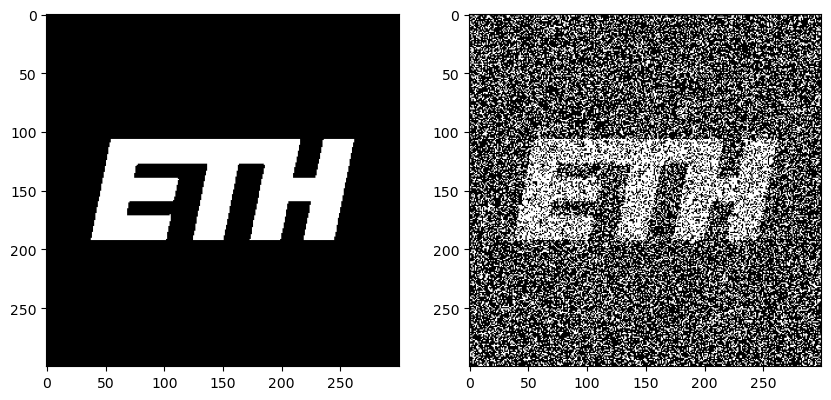

In [4]:
noisy, img = get_images()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Metropolis**: Metropolis algorithm is a MCMC (Markov Chain Monte Carlo) algorithm used to generate samples from a given distribution. It is frequently used in Bayesian inference problems. The algorithm works by proposing a new sample based on the current sample, and accepting or rejecting the new sample based on a probabilistic criterion.

The key formula for Metropolis algorithm is:

Acceptance Probability $= \min(1, \frac{P(\text{new sample})}{P(\text{current sample})})$



- **Metropolis-Hastings**:  Metropolis-Hastings algorithm is also an MCMC algorithm used to generate samples from a target distribution. It is an extension of the Metropolis algorithm, which allows for the proposal distribution to be different from the target distribution. This makes it more flexible than the Metropolis algorithm and can be used when the target distribution is difficult to sample from directly.

The key formula for Metropolis-Hastings algorithm is:

Acceptance Probability $= \min(1, \frac{\frac{P(\text{new sample})}{P(\text{current sample})} \times q(\text{current sample} | \text{new sample})}{q(\text{new sample} | \text{current sample})})$

where $q(\text{current sample} | \text{new sample})$ and $q(\text{new sample} | \text{current sample})$ are the probabilities of proposing the current sample given the new sample and the new sample given the current sample, respectively.




- **Simulated Annealing**: Simulated Annealing is an optimization algorithm used to find the global minimum of a non-convex function. It works by simulating the annealing process in metallurgy, where a material is heated and cooled to obtain a desirable structure. At each iteration of the simulated annealing algorithm, a new point is randomly generated. The distance of the new point from the current point, or the extent of the search, is based on a probability distribution with a scale proportional to the temperature. The algorithm accepts all new points that lower the objective, but also, with a certain probability, points that raise the objective. By accepting points that raise the objective, the algorithm avoids being trapped in local minima, and is able to explore globally for more possible solutions. An annealing schedule is selected to systematically decrease the temperature as the algorithm proceeds. As the temperature decreases, the algorithm reduces the extent of its search to converge to a minimum.

The key formula for Simulated Annealing is:

Acceptance Probability $= \min(1, e^{-\Delta / T})$

where $\Delta$ is the change in the objective function between the current and proposed solutions, $T$ is the current temperature, and $e$ is the exponential function. The acceptance probability decreases as the temperature decreases, allowing the algorithm to escape local minima and search for the global minimum.

<p style="background-color:#adebad;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums. 
    </p>

In [5]:
def get_neighbours(m, i, j):
    neighbours = []
    if i > 0:
        neighbours.append(m[i-1][j])
    if i < len(m)-1:
        neighbours.append(m[i+1][j])
    if j > 0:
        neighbours.append(m[i][j-1])
    if j < len(m[0])-1:
        neighbours.append(m[i][j+1])
    return neighbours
    
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    E = 0
    
    for i in range(height):
        for j in range(width):
        # Your turn
            neighbours = get_neighbours(img_estimate, i, j)
                
            E+= -0.5*beta*(img_estimate[i][j]*sum(neighbours)/len(neighbours))-mu*(img_estimate[i][j]*img_noisy_observation[i][j])
    
    return E 

<p style="background-color:#adebad;">Make sure to get the correct result:</p>

In [6]:
assert np.isclose(energy(*get_images()), -146559.5) or np.isclose(energy(*get_images()), -146934.5)

<p style="background-color:#adebad;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [7]:
def metropolis(img_noisy_observation, epochs, T=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy, estimate))
        
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):
            
            print("Finished {:6.2f}% of epoch {}".format(cnt/n_pixels * 100, e+1), end="\r")
            # Your turn
            i = idx // width
            j = idx % width
            
            x = np.random.uniform()
            new_estimate = estimate.copy()

            new_estimate[i, j] = - new_estimate[i,j]
            new_energy = energy(noisy, new_estimate)
            base_energy = energy(noisy, estimate)
            p = min(np.exp((-new_energy + base_energy)/T), 1)
            if x < p:
                estimate = new_estimate.copy()
    
        energies.append(energy(noisy, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [8]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """

    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()
    
    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#adebad;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

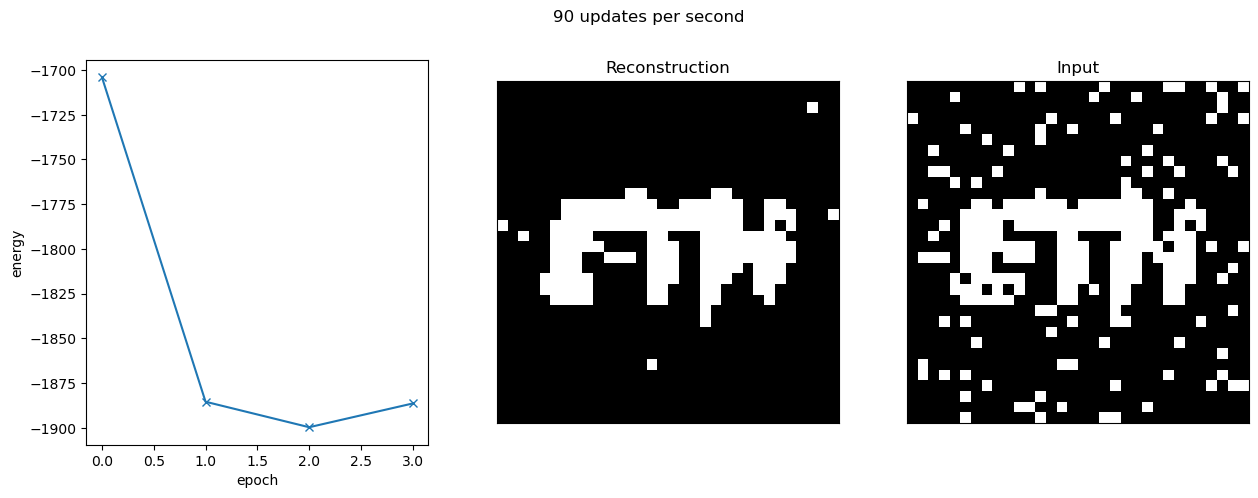

In [9]:
E_metro = evaluate_ising(metropolis, *get_images(size=(32,32), p=0.1), epochs=3)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

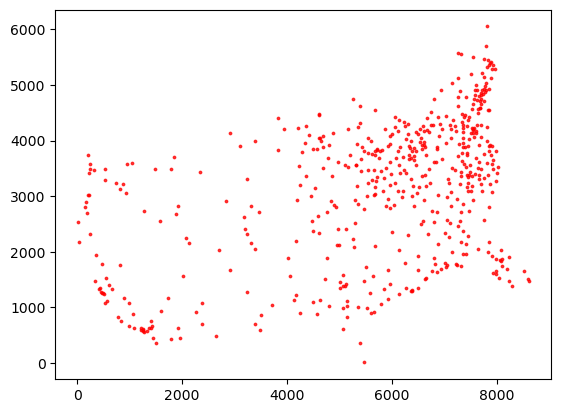

In [10]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()

<p style="background-color:#adebad;">
Implement the distance function for the TSP:
</p>

In [11]:
def distance(coordinates, route=None):
    """Calculate travel distance.
    
    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.
    
    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order
        
    Returns:
        float: traveled distance in units of kilometers
    """
     
    if route is not None:
        coordinates = coordinates[route]

    dist = 0
    for i in range(len(coordinates)-1):
        dist += ((coordinates[i+1][0]-coordinates[i][0])**2+(coordinates[i+1][1]-coordinates[i][1])**2)**0.5

    dist +=  ((coordinates[0][0]-coordinates[531][0])**2+(coordinates[0][1]-coordinates[531][1])**2)**0.5

    return dist/1000

<p style="background-color:#adebad;">
Make sure it returns the correct value:
</p>

In [12]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [13]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates
    
    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)
 
    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")

    x, y = coordinates[route, 0], coordinates[route, 1]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")
    
    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)
    
    plt.show()

<p style="background-color:#adebad;">
First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.
</p>

In [18]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))
    for e in range(epochs):
        for idx in np.random.permutation(N):
            # Your turn
            newroute = route.copy()
            x = np.random.uniform()

            if idx == N-1:
                newroute[idx],newroute[0] = newroute[0],newroute[idx]
            else:
                newroute[idx],newroute[idx+1] = newroute[idx+1],newroute[idx]

            p = min(np.exp((-distance(coordinates, newroute) + distance(coordinates, route))/T), 1)
            
            if x < p:
                route = newroute.copy()
        
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

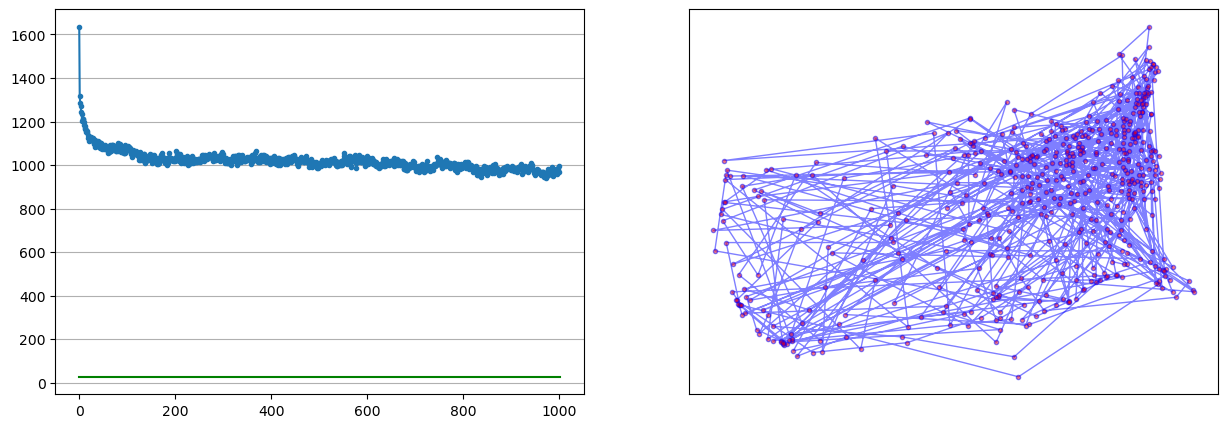

In [19]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [20]:
def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))

    for e in range(epochs):
        for idx in np.random.permutation(N):
            # Your turn
            newroute = route.copy()

            if idx == N-1:
                newroute[idx],newroute[0] = newroute[0],newroute[idx]
            else:
                newroute[idx],newroute[idx+1] = newroute[idx+1],newroute[idx]


            p = min(np.exp(-distance(coordinates, newroute)/(T * eta**e) + distance(coordinates, route)/(T * eta**e)), 1)
            x = np.random.uniform()
            if x < p:
                route = newroute.copy()
        
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

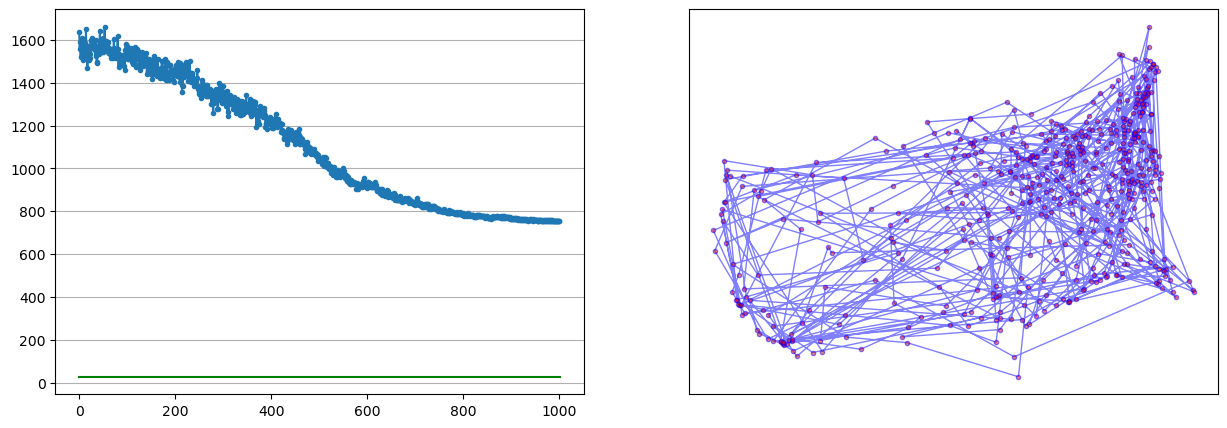

In [21]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [22]:
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """
    
    Local energy difference between unflipped and flipped pixel i,j 
    
    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel
    
    Returns:
        float: local energy difference when pixel i,j is flipped 
    """
    height = estimate.shape[0]
    width = estimate.shape[1]
    dE=0
    newEstimate=estimate.copy()
    newEstimate[i][j]= - newEstimate[i][j]
    
    # Your turn
    def calculate_energy_term(newEstimate, estimate, noisy, i,j):
        
        neighbours = get_neighbours(estimate, i, j)
        E= -0.5*beta*(estimate[i][j]*sum(neighbours)/len(neighbours))-mu*(estimate[i][j]*noisy[i][j])
        
        neighbours = get_neighbours(newEstimate, i, j)
        newE = -0.5*beta*(newEstimate[i][j]*sum(neighbours)/len(neighbours))-mu*(newEstimate[i][j]*noisy[i][j])
        
        return newE-E
    
    dE+= calculate_energy_term(newEstimate, estimate, noisy , i,j) 
    
    if i > 0:
        dE += calculate_energy_term(newEstimate, estimate, noisy, i-1,j) 
        
    if i < len(estimate)-1:
        dE += calculate_energy_term(newEstimate, estimate, noisy, i+1,j) 
        
    if j > 0:
        dE += calculate_energy_term(newEstimate, estimate, noisy, i,j-1)
        
    if j < len(estimate[0])-1:
        dE += calculate_energy_term(newEstimate, estimate, noisy, i,j+1)
        
    return dE

def local_metropolis(img_noisy_observation, epochs, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using local_energy_change 

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    
    for e in range(epochs):
        if e == 0:
            energies.append(energy(noisy, estimate))
        
        for cnt, pix in enumerate(np.random.permutation(n_pixels)):
            # Your turn
            i = pix // width
            j = pix % width

            
            new_estimate = estimate.copy()
            new_estimate[i, j] = - new_estimate[i, j]
            dE = local_energy_change(noisy, estimate, i, j, beta, mu)
            
            p = min(np.exp(-dE/T), 1)
            x = np.random.uniform()
            if x < p:
                estimate = new_estimate.copy()
        
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

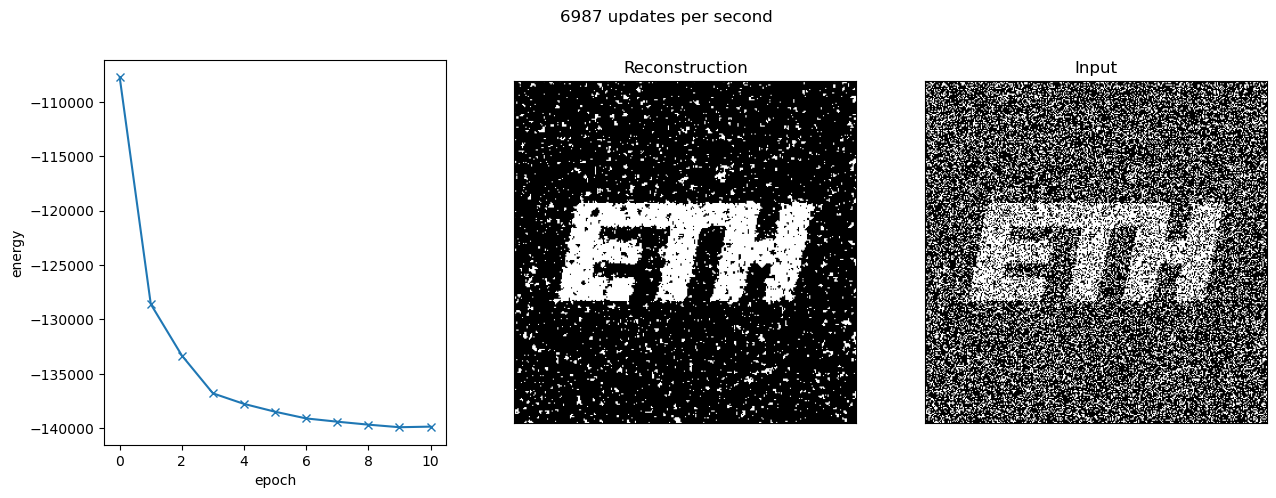

(-139862.58333333314, 0.07026666666666667)

In [23]:
E_local = evaluate_ising(local_metropolis, *get_images(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *get_images(), epochs=10)

In [24]:
E_local

(-1886.4166666666665, 0.0322265625)

In [25]:
E_metro

(-1886.4166666666665, 0.0322265625)

<p style="background-color:#adebad;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [26]:
assert E_metro == E_local

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [27]:
def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
    """Compute energy change when flipping pixels in grid
    
    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.
    
    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: Flat array or list of grid indices.
    
    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.
    
    """
        
    neighbours = 0.25*fftconvolve(estimate, np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]), mode='same')
    
    kernel = np.array([[0, 0.25*beta, 0], [0.25*beta, 0, 0.25*beta], [0, 0.25*beta, 0]])
    dE = fftconvolve(estimate, kernel, mode='same')*estimate
    
    dE += beta*estimate*neighbours + 2*mu*estimate*noisy_img
    energy_change = dE[grid[:, 0], grid[:, 1]]
    
    return energy_change


In [32]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    n_pixels = img_noisy_observation.size
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    width= img_noisy_observation.shape[1]
 
    # Your turn, definition of grids
    n_rows, n_cols = img_noisy_observation.shape

    x, y = np.meshgrid(np.arange(n_cols), np.arange(n_rows), indexing='ij')
    grid = (x + y) % 2
    grids = [np.argwhere(grid == 0), np.argwhere(grid == 1)]


    energies = []
    for e in range(epochs):

        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for grid in grids:
            new_estimate = estimate.copy()
            
            dE = checkerboard_energy_change(noisy_img, estimate, grid, beta, mu)
            p = np.minimum(np.exp(-dE/T), 1)
            x = np.random.uniform(size=grid.shape[0])
            indices_to_flip = (x < p).astype(bool)
            
            new_estimate[grid[indices_to_flip][:, 0], grid[indices_to_flip][:, 1]] = -new_estimate[grid[indices_to_flip][:, 0], grid[indices_to_flip][:, 1]]
            
            estimate = new_estimate.copy()

                
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Run the checkerboard_metropolis:
    </p>

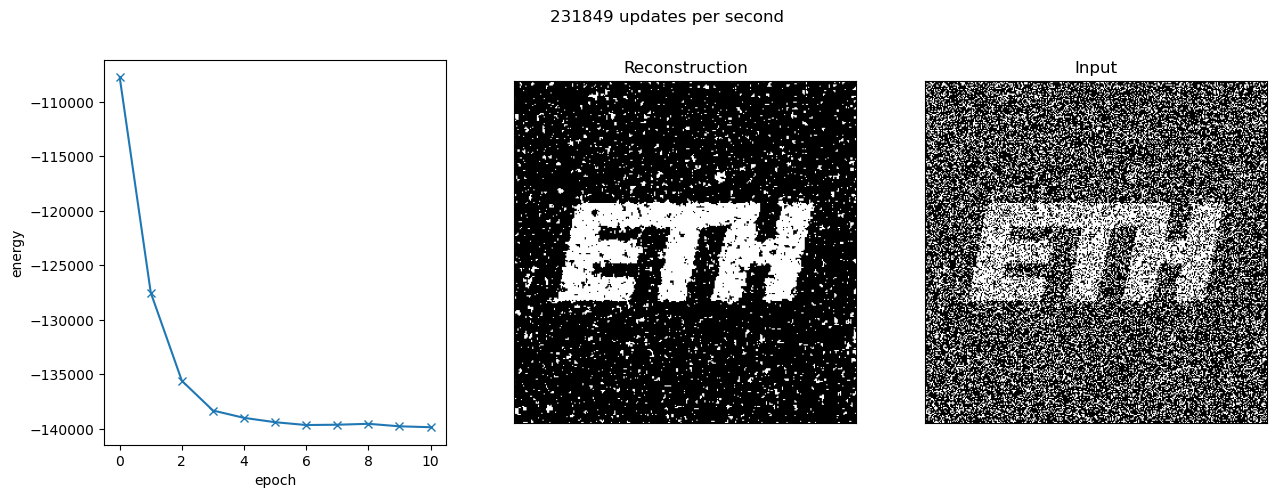

(-139847.37499999968, 0.06726666666666667)

In [33]:
evaluate_ising(checkerboard_metropolis, *get_images(), epochs=10)

<p style="background-color:#adebad;">
    Run the experiment below, and explain the observed behavior!
    </p>

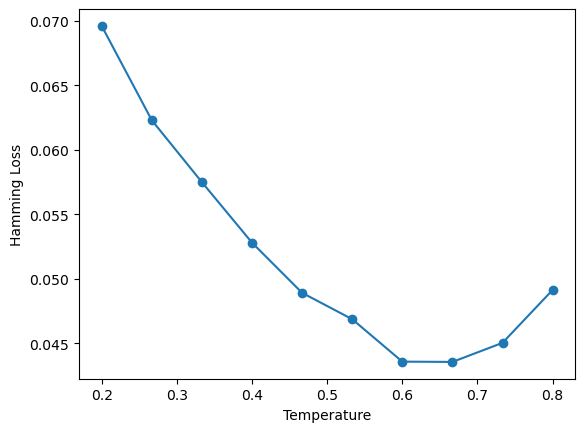

In [34]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *get_images(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

Write your explanation here

If the value of $T$ is small, the algorithm may be trapped in a local minimum. Increasing the value of $T$ allows the algorithm to explore more locations (by allowing the loss function to increase temporarily) and find a better local minimum. However, if $T$ becomes too large, the algorithm may jump to worse local minimums.

<p style="background-color:#adebad;">
Run the experiment below, and explain the observed behavior!
</p>

In [ ]:
def find_Topt(p):
    f = lambda T: evaluate_ising(checkerboard_metropolis, *get_images(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x

prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()) as pool:
    Topt = pool.map(find_Topt, prange)
    
plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()

Write your explanation here

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    $p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)
</p>

In [ ]:
def myfancyalgorithm(coordinates, route=None, epochs=1):
    
    np.random.seed(7)
    
    #
    #
    # Your turn
    #
    #
    
    return np.asarray(route), np.asarray(distances) 

<p style="background-color:#adebad;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

In [ ]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=500)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.